In [1]:
# required modules (skip if already installed)
if False:
    !pip install pyroaring
    !pip install pyfim 
    # if previous does not work, try: !conda install -c conda-forge pyfim
    !pip install lightgbm
    !pip install fairlearn

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# global imports
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# local imports
sys.path.append('../src/') # local path
import dd

In [3]:
# read folkstable data
census = pd.read_pickle('../data/ACSIncome.pkl') 
states = list(census['STATE'].unique())
# change to True to binarize RAC1P
if False: 
    census["RAC1P"][census["RAC1P"]!='White alone'] = 'Not White alone'

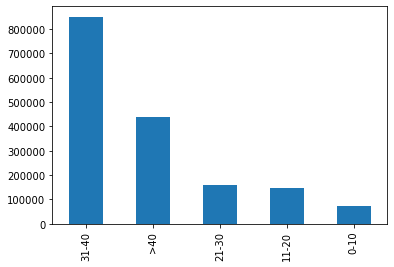

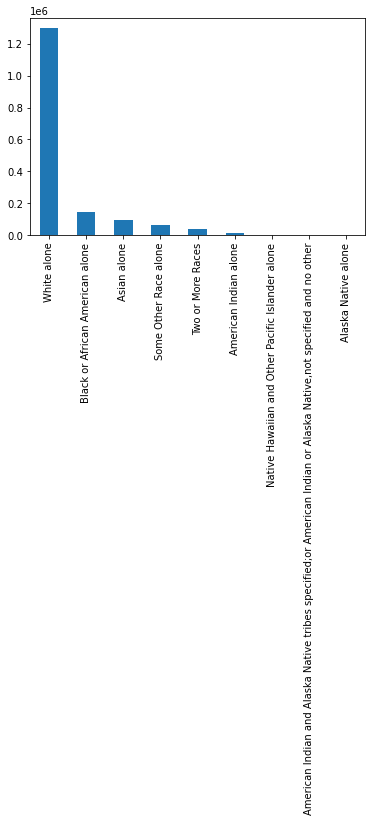

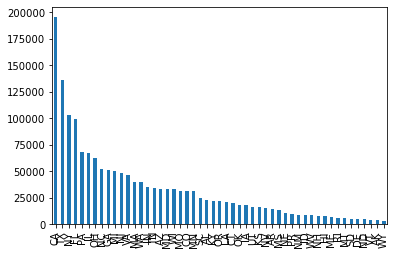

In [4]:
# distributions
census["WKHPgroup"].value_counts().plot(kind='bar')
plt.show()
census["RAC1P"].value_counts().plot(kind='bar')
plt.show()
census["STATE"].value_counts().plot(kind='bar')
plt.show()

In [5]:
# there are no missing values
census.isna().sum()

AGEP         0
COW          0
SCHL         0
MAR          0
OCCP         0
POBP         0
WKHP         0
SEX          0
RAC1P        0
STATE        0
class        0
WKHPgroup    0
AGEPgroup    0
POBPgroup    0
OCCPgroup    0
dtype: int64

In [6]:
# predictive attributes (for models)
pred_atts = ['AGEP', 'COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'WKHP', 'SEX', 'RAC1P', 'STATE']
pred_all = pred_atts + ['class']
# discretized attributes (for DD)
disc_atts = ['AGEPgroup', 'COW', 'SCHL', 'MAR', 'OCCPgroup', 'POBPgroup', 'WKHPgroup', 'SEX', 'RAC1P', 'STATE']
disc_all = disc_atts + ['class']
# encode categorical values
df, encoders = dd.encode(census)
df.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,WKHP,SEX,RAC1P,STATE,class,WKHPgroup,AGEPgroup,POBPgroup,OCCPgroup
0,1.0,0.0,23.0,2.0,296.0,10.0,20.0,0.0,4.0,1.0,0.0,1.0,0.0,5.0,22.0
1,36.0,2.0,5.0,2.0,225.0,14.0,39.0,1.0,8.0,1.0,0.0,3.0,3.0,5.0,12.0
2,24.0,0.0,22.0,2.0,421.0,0.0,39.0,1.0,8.0,1.0,0.0,3.0,1.0,5.0,21.0
3,1.0,5.0,23.0,2.0,161.0,0.0,1.0,0.0,8.0,1.0,0.0,0.0,0.0,5.0,8.0
4,4.0,2.0,0.0,2.0,246.0,9.0,49.0,1.0,8.0,1.0,0.0,4.0,0.0,5.0,20.0


In [7]:
# 0 = negative, 1 = positive
encoders['class'].classes_

array([False,  True])

In [8]:
# pretty printing long labels
pretty_rac1p = ['Alaskian', 'Indian', 'Alaskian-Indian', 'Asian', 'Black', 'Hawaiian', 'Other', 'Two+', 'White']
rac1p_2_pretty = { encoders['RAC1P'].classes_[i]:pretty_rac1p[i] for i in range(len(pretty_rac1p)) }
rac1p_2_pretty

{'Alaska Native alone': 'Alaska',
 'American Indian alone': 'Indian',
 'American Indian and Alaska Native tribes specified;or American Indian or Alaska Native,not specified and no other': 'Alaska-Indian',
 'Asian alone': 'Asian',
 'Black or African American alone': 'Black',
 'Native Hawaiian and Other Pacific Islander alone': 'Hawaiian',
 'Some Other Race alone': 'Other',
 'Two or More Races': 'Two+',
 'White alone': 'White'}

In [9]:
# split train test
X = df[pred_atts]
y = df['class'].astype(int)
X_train, X_test, y_train, y_test, census_train, census_test = train_test_split(X, y, census, test_size=0.33, random_state=42)

In [10]:
# training model and make predictions - replace with your favorite classifier
import lightgbm as lgb

clf = lgb.LGBMClassifier(random_state=42)
clf.fit(X_train, y_train)
# add predicted class in the census dataset (decoding back)
y_pred_b = clf.predict(X_test)
census_test['pred_b'] = encoders['class'].inverse_transform(y_pred_b)
# add predicted score in the adult_test
census_test['score'] = clf.predict_proba(X_test)[:,1]
census_test.head()

,AGEP,COW,SCHL,MAR,OCCP,POBP,WKHP,SEX,RAC1P,STATE,class,WKHPgroup,AGEPgroup,POBPgroup,OCCPgroup,pred_b,score
517717,28,Employee of a private for-profit company orbus...,"Some college, but less than 1 year",Never married or under 15 years old,4700.0,37,50.0,Female,White alone,IL,False,>40,16-30,US,SAL,False,0.246374
319156,56,Federal government employee,"Some college, but less than 1 year",Divorced,4230.0,36,40.0,Male,Black or African American alone,CT,False,31-40,51-60,US,CLN,False,0.270322
507501,23,Employee of a private for-profit company orbus...,Bachelor's degree,Never married or under 15 years old,1430.0,36,40.0,Male,White alone,IL,True,31-40,16-30,US,ENG,False,0.422198
537835,33,Employee of a private for-profit company orbus...,Bachelor's degree,Married,4710.0,17,50.0,Female,White alone,IL,True,>40,31-40,US,SAL,True,0.833683
305930,38,Employee of a private for-profit company orbus...,Doctorate degree,Married,3250.0,34,40.0,Female,White alone,CT,True,31-40,31-40,US,MED,True,0.917323


### Independence metrics: how much discrimination in the predictions?

In [11]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_b = dd.DD(census_test[disc_all+['pred_b']], unprotectedItem='RAC1P=White alone', predBadItem='pred_b=False')    
# all protected vs unprotected
ctg = disc_b.ctg_any()
disc_b.print(ctg)
print("RD = {:f}".format(ctg.rd()))
# each protected vs unprotected
for ctg in disc_b.ctg_global():
    disc_b.print(ctg)
    print("RD = {:f}".format(ctg.rd()))

-----
Context ALL
Size = 549285  Perc = 100.00%
                  |pred_b=False|pred_b=True|      
RAC1P!=White alone|       89501|      31384|120885
RAC1P=White alone |      266131|     162269|428400
                  |      355632|     193653|549285
RD = 0.119161
-----
Context ALL
Size = 549285  Perc = 100.00%
                                     |pred_b=False|pred_b=True|      
RAC1P=Black or African American alone|       38793|       9726| 48519
RAC1P=White alone                    |      266131|     162269|428400
                                     |      304924|     171995|476919
RD = 0.178322
-----
Context ALL
Size = 549285  Perc = 100.00%
                       |pred_b=False|pred_b=True|      
RAC1P=Two or More Races|       10096|       3744| 13840
RAC1P=White alone      |      266131|     162269|428400
                       |      276227|     166013|442240
RD = 0.108259
-----
Context ALL
Size = 549285  Perc = 100.00%
                 |pred_b=False|pred_b=True|      
RAC1P=As

### Independence metrics: how much discrimination in the ground truth (perfect model)?

In [12]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_gt = dd.DD(census_test[disc_all], unprotectedItem='RAC1P=White alone', predBadItem='class=False')    
# all protected vs unprotected
ctg = disc_gt.ctg_any()
disc_gt.print(ctg)
print("RD = {:f}".format(ctg.rd()))
# each protected vs unprotected
for ctg in disc_gt.ctg_global():
    disc_gt.print(ctg)
    print("RD = {:f}".format(ctg.rd()))

-----
Context ALL
Size = 549285  Perc = 100.00%
                  |class=False|class=True|      
RAC1P!=White alone|      85449|     35436|120885
RAC1P=White alone |     261497|    166903|428400
                  |     346946|    202339|549285
RD = 0.096458
-----
Context ALL
Size = 549285  Perc = 100.00%
                                     |class=False|class=True|      
RAC1P=Black or African American alone|      36568|     11951| 48519
RAC1P=White alone                    |     261497|    166903|428400
                                     |     298065|    178854|476919
RD = 0.143280
-----
Context ALL
Size = 549285  Perc = 100.00%
                       |class=False|class=True|      
RAC1P=Two or More Races|       9720|      4120| 13840
RAC1P=White alone      |     261497|    166903|428400
                       |     271217|    171023|442240
RD = 0.091908
-----
Context ALL
Size = 549285  Perc = 100.00%
                 |class=False|class=True|      
RAC1P=Asian alone|      17520|    

In [13]:
m_gt = dict()
m_b = dict()
for ctg in disc_gt.ctg_global():
    _, pr = disc_gt.ctg_info(ctg)
    pro = rac1p_2_pretty[dd.get_val(pr)]
    m_gt[pro] = ctg.rd()
    m_b[pro] = disc_b.ctg_rel(ctg).rd()
m_gt = [value for key,value in sorted(m_gt.items())]
m_b = [value for key,value in sorted(m_b.items())]

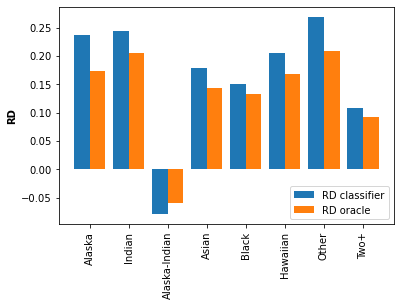

In [14]:
X_axis = np.arange(len(pretty_rac1p)-1)
plt.bar(X_axis - 0.2, m_b, 0.4, label='RD classifier')
plt.bar(X_axis + 0.2, m_gt, 0.4, label='RD oracle')
plt.xticks(X_axis, pretty_rac1p[:-1])
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("RD", fontweight="bold")
plt.show()

### Independence metrics: discovering discrimination in predictions

In [15]:
# filtering condition: return None to filter out, or measure value
# contingency table ctg such that ctg.n() >= minSupp 
'''
     contingency table for independence
     =========== pred.bad === pred.good === 
     protected       a            b       n1()
     unprotected     c            d       n2()
     ===========    m1()  ===    m2()  ==  n()
'''
def check_rd(ctg):
    # at least 20 protected
    return ctg.rd() if ctg.a >= 20 and ctg.n2() > 0 else None

def check_rr(ctg):
    # at least 20 protected 
    return ctg.rr() if ctg.a >= 20 and ctg.n2() > 0 else None

In [16]:
# Extract contingency tables: 
# minSupp = min support of context (negative = absolute, positive = percentage)
# topk = top k contingency tables
ctgs_rd = disc_b.extract(testCond=check_rd, minSupp=-100, topk=1000)
ctgs_rr = disc_b.extract(testCond=check_rr, minSupp=-100, topk=1000)

In [17]:
# top 3 wrt RD
for v, ctg in ctgs_rd[:3]:
    disc_b.print(ctg)
    print("RD = {:f}".format(v))

-----
Context STATE=HI AND POBPgroup=Asia AND MAR=Married AND class=False AND COW=Employee of a private for-profit company orbusiness, or of an individual, for wages,salary, or commissions
Size = 142  Perc = 0.03%
                 |pred_b=False|pred_b=True|   
RAC1P=Asian alone|         126|         11|137
RAC1P=White alone|           0|          1|  1
                 |         126|         12|138
RD = 0.919708
-----
Context STATE=HI AND POBPgroup=Asia AND MAR=Married AND class=False
Size = 186  Perc = 0.03%
                 |pred_b=False|pred_b=True|   
RAC1P=Asian alone|         158|         21|179
RAC1P=White alone|           0|          2|  2
                 |         158|         23|181
RD = 0.882682
-----
Context STATE=HI AND POBPgroup=Asia AND WKHPgroup=31-40 AND MAR=Married AND COW=Employee of a private for-profit company orbusiness, or of an individual, for wages,salary, or commissions
Size = 126  Perc = 0.02%
                 |pred_b=False|pred_b=True|   
RAC1P=Asian alone|

In [18]:
# top 3 wrt RR
for v, ctg in ctgs_rr[:3]:
    disc_b.print(ctg)
    print("RR = {:f}".format(v))

-----
Context POBPgroup=Africa AND AGEPgroup=41-50 AND WKHPgroup=>40 AND MAR=Married AND COW=Employee of a private for-profit company orbusiness, or of an individual, for wages,salary, or commissions
Size = 120  Perc = 0.02%
                                     |pred_b=False|pred_b=True|   
RAC1P=Black or African American alone|          35|         36| 71
RAC1P=White alone                    |           0|         41| 41
                                     |          35|         77|112
RR = 20.704225
-----
Context POBPgroup=Africa AND WKHPgroup=>40 AND class=True AND SEX=Male AND MAR=Married AND COW=Employee of a private for-profit company orbusiness, or of an individual, for wages,salary, or commissions
Size = 167  Perc = 0.03%
                                     |pred_b=False|pred_b=True|   
RAC1P=Black or African American alone|          20|         58| 78
RAC1P=White alone                    |           1|         79| 80
                                     |          21|       

In [19]:
# contingency tables in ctgs_rd
ct_rd_set = set(ctg[1] for ctg in ctgs_rd)
# contingency tables in ctgs_rd
ct_rr_set = set(ctg[1] for ctg in ctgs_rr)
# contingency tables in both
shared = ct_rd_set & ct_rr_set
len(shared) 

269

Text(0, 0.5, 'p2')

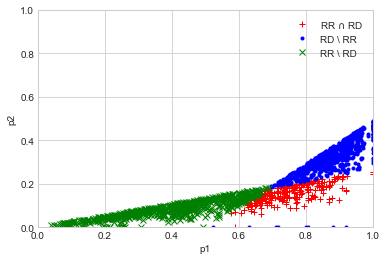

In [20]:
# plot p1() vs p2() for top-k contingency tables
plt.style.use('seaborn-whitegrid')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot([ctg.p1() for ctg in shared], [ctg.p2() for ctg in shared], '+', color='red', label=r'RR $\cap$ RD')
only_rd = ct_rd_set - shared
plt.plot([ctg.p1() for ctg in only_rd], [ctg.p2() for ctg in only_rd], '.', color='blue', label=r'RD \ RR')
only_rr = ct_rr_set - shared
plt.plot([ctg.p1() for ctg in only_rr], [ctg.p2() for ctg in only_rr], 'x', color='green', label=r'RR \ RD')
plt.legend()
plt.xlabel('p1')
plt.ylabel('p2')

### Independence metrics: correcting the classifier

In [21]:
# Fairlearn algorithms and utils (https://github.com/fairlearn/fairlearn)
# or try your preferred fair ML tool
from fairlearn.postprocessing import ThresholdOptimizer
# fairness by post-processing
postprocess_est = ThresholdOptimizer(estimator=clf, constraints="demographic_parity", prefit=True, predict_method='predict')
X_train = X_train.fillna(0) # fairlearn does not manage missing values
X_test = X_test.fillna(0) # fairlearn does not manage missing values
postprocess_est.fit(X_train, y_train, sensitive_features=X_train['RAC1P'])
# fair-corrected predictions 
y_pred_a = postprocess_est.predict(X_test, sensitive_features=X_test['RAC1P']).astype(int)
census_test['pred_a'] = encoders['class'].inverse_transform(y_pred_a)

In [22]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_a = dd.DD(census_test[disc_all+['pred_a']], unprotectedItem='RAC1P=White alone', predBadItem='pred_a=False')    
# all protected vs unprotected
ctg = disc_a.ctg_any()
disc_b.print(ctg)
print("RD = {:f}".format(ctg.rd()))
# each protected vs unprotected
for ctg in disc_a.ctg_global():
    disc_a.print(ctg)
    print("RD = {:f}".format(ctg.rd()))

-----
Context ALL
Size = 549285  Perc = 100.00%
                  |pred_b=False|pred_b=True|      
RAC1P!=White alone|       75042|      45843|120885
RAC1P=White alone |      266142|     162258|428400
                  |      341184|     208101|549285
RD = -0.000475
-----
Context ALL
Size = 549285  Perc = 100.00%
                                     |pred_a=False|pred_a=True|      
RAC1P=Black or African American alone|       30097|      18422| 48519
RAC1P=White alone                    |      266142|     162258|428400
                                     |      296239|     180680|476919
RD = -0.000933
-----
Context ALL
Size = 549285  Perc = 100.00%
                       |pred_a=False|pred_a=True|      
RAC1P=Two or More Races|        8592|       5248| 13840
RAC1P=White alone      |      266142|     162258|428400
                       |      274734|     167506|442240
RD = -0.000437
-----
Context ALL
Size = 549285  Perc = 100.00%
                 |pred_a=False|pred_a=True|      
RAC1P

In [23]:
m_a = dict()
for ctg in disc_a.ctg_global():
    _, pr = disc_a.ctg_info(ctg)
    pro = rac1p_2_pretty[dd.get_val(pr)]
    m_a[pro] = ctg.rd()
m_a = [value for key,value in sorted(m_a.items())]

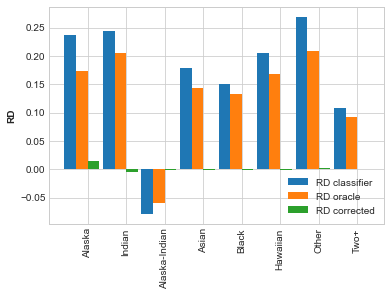

In [24]:
X_axis = np.arange(len(pretty_rac1p)-1)
plt.bar(X_axis - 0.45, m_b, 0.3, label='RD classifier')
plt.bar(X_axis - 0.15, m_gt, 0.3, label='RD oracle')
plt.bar(X_axis + 0.15, m_a, 0.3, label='RD corrected')
plt.xticks(X_axis, pretty_rac1p[:-1])
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("RD", fontweight="bold")
plt.show()

In [25]:
# compare accuracies
print('ACC classifier', np.mean(y_test == y_pred_b))
print('ACC corrected', np.mean(y_test == y_pred_a))

ACC classifier 0.8211493122877923
ACC corrected 0.7950207997669698


### Separation metrics: how much discrimination in the predictions?

In [26]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_b = dd.DD(census_test[disc_all+['pred_b']], unprotectedItem='RAC1P=White alone', 
               predBadItem='pred_b=False', trueBadItem='class=False')    
# all protected vs unprotected
ctg = disc_b.ctg_any()
disc_b.print(ctg)
print("EOP = {:f}".format(ctg.eop()))
# each protected vs unprotected
for ctg in disc_b.ctg_global():
    disc_b.print(ctg)
    print("EOP = {:f}".format(ctg.eop()))

-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P!=White alone                               RAC1P=White alone
           |pred_b=False|pred_b=True|                      |pred_b=False|pred_b=True|      
class=False|       77910|       7539| 85449     class=False|      224259|      37238|261497
class=True |       11591|      23845| 35436     class=True |       41872|     125031|166903
           |       89501|      31384|120885                |      162269|     266131|428400
EOP = 0.076220
-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P=Black or African American alone           RAC1P=White alone
           |pred_b=False|pred_b=True|                      |pred_b=False|pred_b=True|      
class=False|       33778|       2790| 36568     class=False|      224259|      37238|261497
class=True |        5015|       6936| 11951     class=True |       41872|     125031|166903
           |       38793|       9726| 48519                |      162269|     266131|428400
EOP = 0.168754
-----

### Separation metrics: correcting the classifier

In [27]:
postprocess_est = ThresholdOptimizer(estimator=clf, constraints="true_positive_rate_parity", prefit=True, predict_method='predict')
postprocess_est.fit(X_train, y_train, sensitive_features=X_train['RAC1P'])
# fair-corrected predictions 
y_pred_a = postprocess_est.predict(X_test, sensitive_features=X_test['RAC1P']).astype(int)
census_test['pred_a'] = encoders['class'].inverse_transform(y_pred_a)

In [28]:
# DD(filename or dataframe, unprotectedItem, predBadItem)
disc_a = dd.DD(census_test[disc_all+['pred_a']], unprotectedItem='RAC1P=White alone', 
               predBadItem='pred_a=False', trueBadItem='class=False')    
# all protected vs unprotected
ctg = disc_a.ctg_any()
disc_b.print(ctg)
print("EOP = {:f}".format(ctg.eop()))
# each protected vs unprotected
for ctg in disc_a.ctg_global():
    disc_a.print(ctg)
    print("EOP = {:f}".format(ctg.eop()))

-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P!=White alone                               RAC1P=White alone
           |pred_b=False|pred_b=True|                      |pred_b=False|pred_b=True|      
class=False|       60043|      25406| 85449     class=False|      226901|      34596|261497
class=True |       10873|      24563| 35436     class=True |       50635|     116268|166903
           |       70916|      49969|120885                |      150864|     277536|428400
EOP = 0.003455
-----
Context ALL
Size = 549285  Perc = 100.00%
RAC1P=Black or African American alone           RAC1P=White alone
           |pred_a=False|pred_a=True|                      |pred_a=False|pred_a=True|      
class=False|       24796|      11772| 36568     class=False|      226901|      34596|261497
class=True |        3720|       8231| 11951     class=True |       50635|     116268|166903
           |       28516|      20003| 48519                |      150864|     277536|428400
EOP = 0.007891
-----

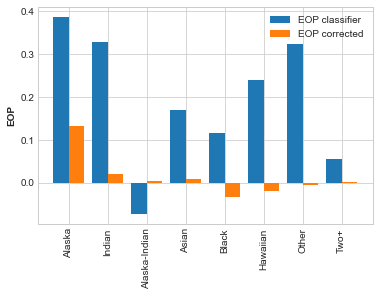

In [29]:
m_a = dict()
m_b = dict()
for ctg in disc_a.ctg_global():
    _, pr = disc_a.ctg_info(ctg)
    pro = rac1p_2_pretty[dd.get_val(pr)]
    m_a[pro] = ctg.eop()
    m_b[pro] = disc_b.ctg_rel(ctg).eop()
m_a = [value for key,value in sorted(m_a.items())]
m_b = [value for key,value in sorted(m_b.items())]

X_axis = np.arange(len(pretty_rac1p)-1)
plt.bar(X_axis - 0.2, m_b, 0.4, label='EOP classifier')
plt.bar(X_axis + 0.2, m_a, 0.4, label='EOP corrected')
plt.xticks(X_axis, pretty_rac1p[:-1])
plt.xticks(rotation=90)
plt.legend()
plt.ylabel("EOP", fontweight="bold")
plt.show()

In [30]:
# compare accuracies
print('ACC classifier', np.mean(y_test == y_pred_b))
print('ACC corrected', np.mean(y_test == y_pred_a))

ACC classifier 0.8211493122877923
ACC corrected 0.7787851479650819
